This Kernel is a deep dive into image classification. CNN for classification model. 



# Import Library

In [26]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("./input"))


['test1', 'train']


# Define Constants

In [27]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Traning Data

In [28]:
filenames = os.listdir("./input/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [29]:
df.head()

,filename,category
0,dog.2757.jpg,1
1,dog.10769.jpg,1
2,dog.12050.jpg,1
3,cat.9753.jpg,0
4,dog.3798.jpg,1


In [30]:
df.tail()

,filename,category
24995,cat.10782.jpg,0
24996,cat.7813.jpg,0
24997,cat.2265.jpg,0
24998,dog.5503.jpg,1
24999,cat.6261.jpg,0


### See Total In count

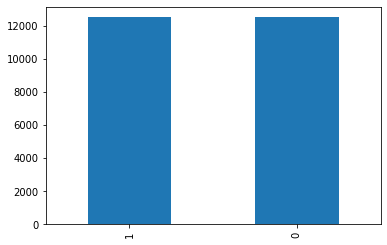

In [31]:
df['category'].value_counts().plot.bar()

From our data we have 12000 cats and 12000 dogs

# See sample image

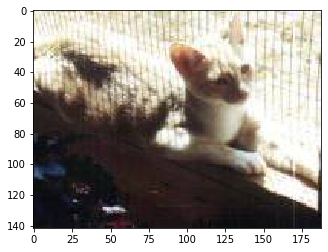

In [32]:
sample = random.choice(filenames)
image = load_img("./input/train/"+sample)
plt.imshow(image)

# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Input Layer**: It represents input image data. It will reshape images into single dimension array. E.g. your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer extracts features from image.
* **Pooling Layer**: This layer reduces the spatial volume of input image after convolution.
* **Fully Connected Layer**: Connects the network from a layer to another layer
* **Output Layer**: It is the predicted values layer. 

In [33]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)       

# Callbacks

In [34]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value is not decreased

In [35]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy does not increase for 2 steps

In [36]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [37]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

Because we will use image generetor `with class_mode="categorical"`. We need to convert column category into string. Then image generator will convert it one-hot encoding which is good for our classification. 

So we will convert 1 to dog and 0 to cat

In [38]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [39]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

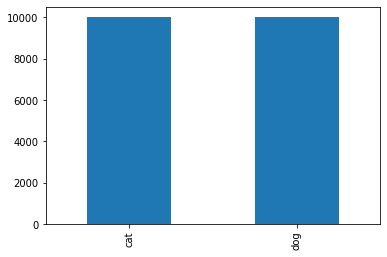

In [40]:
train_df['category'].value_counts().plot.bar()

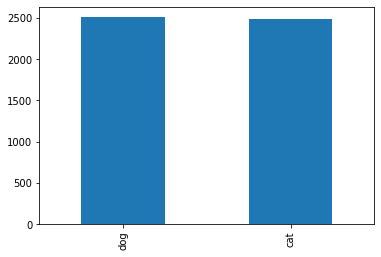

In [41]:
validate_df['category'].value_counts().plot.bar()

In [42]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Traning Generator

In [43]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation Generator

In [44]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


# See how our generator work

In [45]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


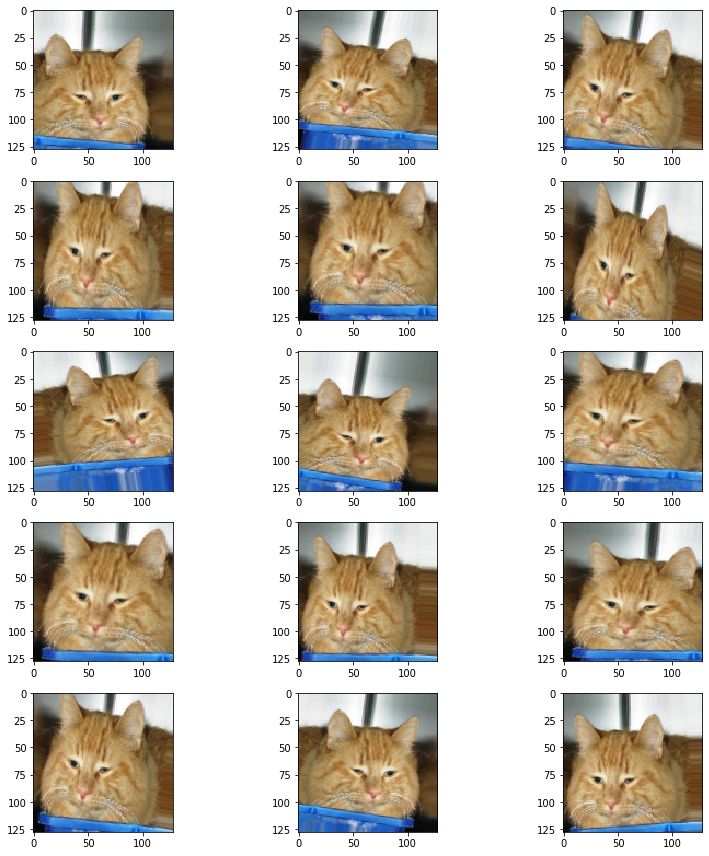

In [46]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice 

# Fit Model

In [48]:
FAST_RUN = 'false'
epochs=5 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
1333/1333 [==============================] - 674s 506ms/step - loss: 0.7247 - accuracy: 0.6441 - val_loss: 0.5135 - val_accuracy: 0.7005
Epoch 2/50


/home/reaper/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1333/1333 [==============================] - 657s 493ms/step - loss: 0.5555 - accuracy: 0.7219 - val_loss: 0.5819 - val_accuracy: 0.6560
Epoch 3/50
1333/1333 [==============================] - 613s 460ms/step - loss: 0.4956 - accuracy: 0.7671 - val_loss: 0.3324 - val_accuracy: 0.8014
Epoch 4/50
1333/1333 [==============================] - 596s 447ms/step - loss: 0.4582 - accuracy: 0.7902 - val_loss: 0.2576 - val_accuracy: 0.7876
Epoch 5/50
1333/1333 [==============================] - 588s 441ms/step - loss: 0.4331 - accuracy: 0.8023 - val_loss: 0.3675 - val_accuracy: 0.8315
Epoch 6/50
1333/1333 [==============================] - 586s 440ms/step - loss: 0.4127 - accuracy: 0.8175 - val_loss: 0.3926 - val_accuracy: 0.8098
Epoch 7/50
1333/1333 [==============================] - 593s 445ms/step - loss: 0.3989 - accuracy: 0.8199 - val_loss: 0.5004 - val_accuracy: 0.7202
Epoch 8/50
 512/1333 [==========>...................] - ETA: 5:49 - loss: 0.3791 - accuracy: 0.8323

KeyboardInterrupt: 

# Save Model

In [45]:
model.save_weights("model.h5")

# Virtualize Training

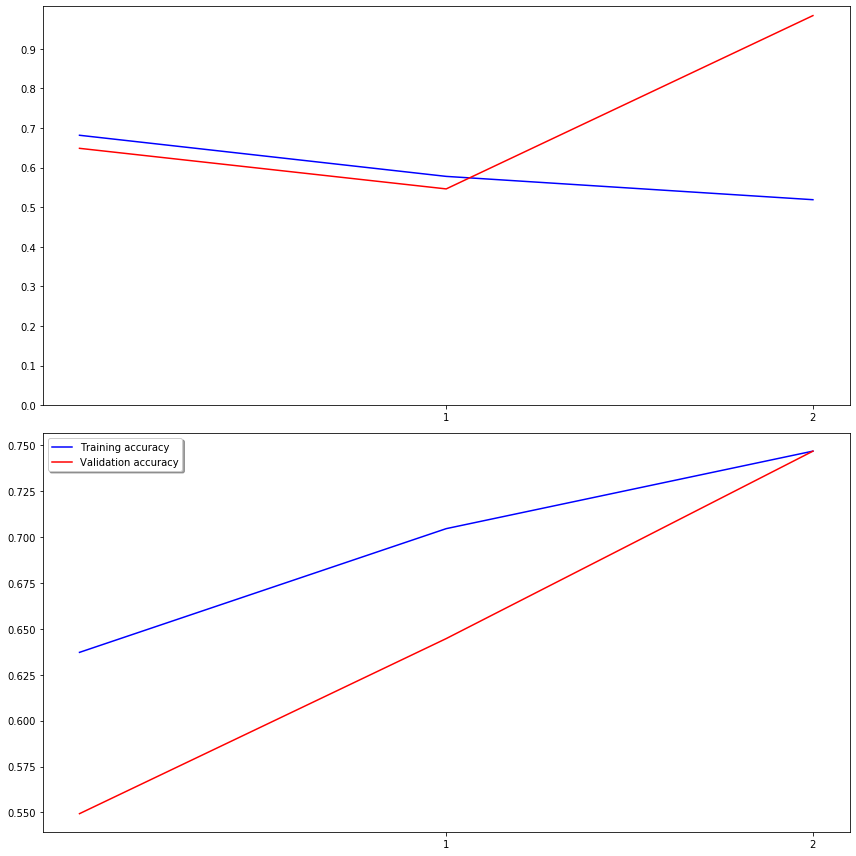

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [47]:
test_filenames = os.listdir("./input/test1/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [48]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./input/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


# Predict

In [49]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
For categoral classication the prediction will come with probability of each category. So we will pick the category that has the highest probability with numpy average max

In [50]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes the image generator maps while converting data into computer vision

In [51]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with `{1: 'dog', 0: 'cat'}`. Now we will map the result back to 1 for dog and 0 for cat

In [52]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

### Virtaulize Result

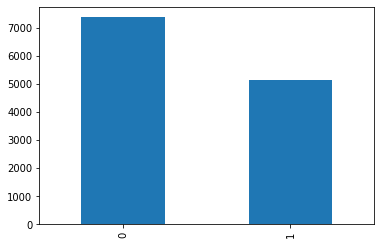

In [53]:
test_df['category'].value_counts().plot.bar()

### See predicted result with images

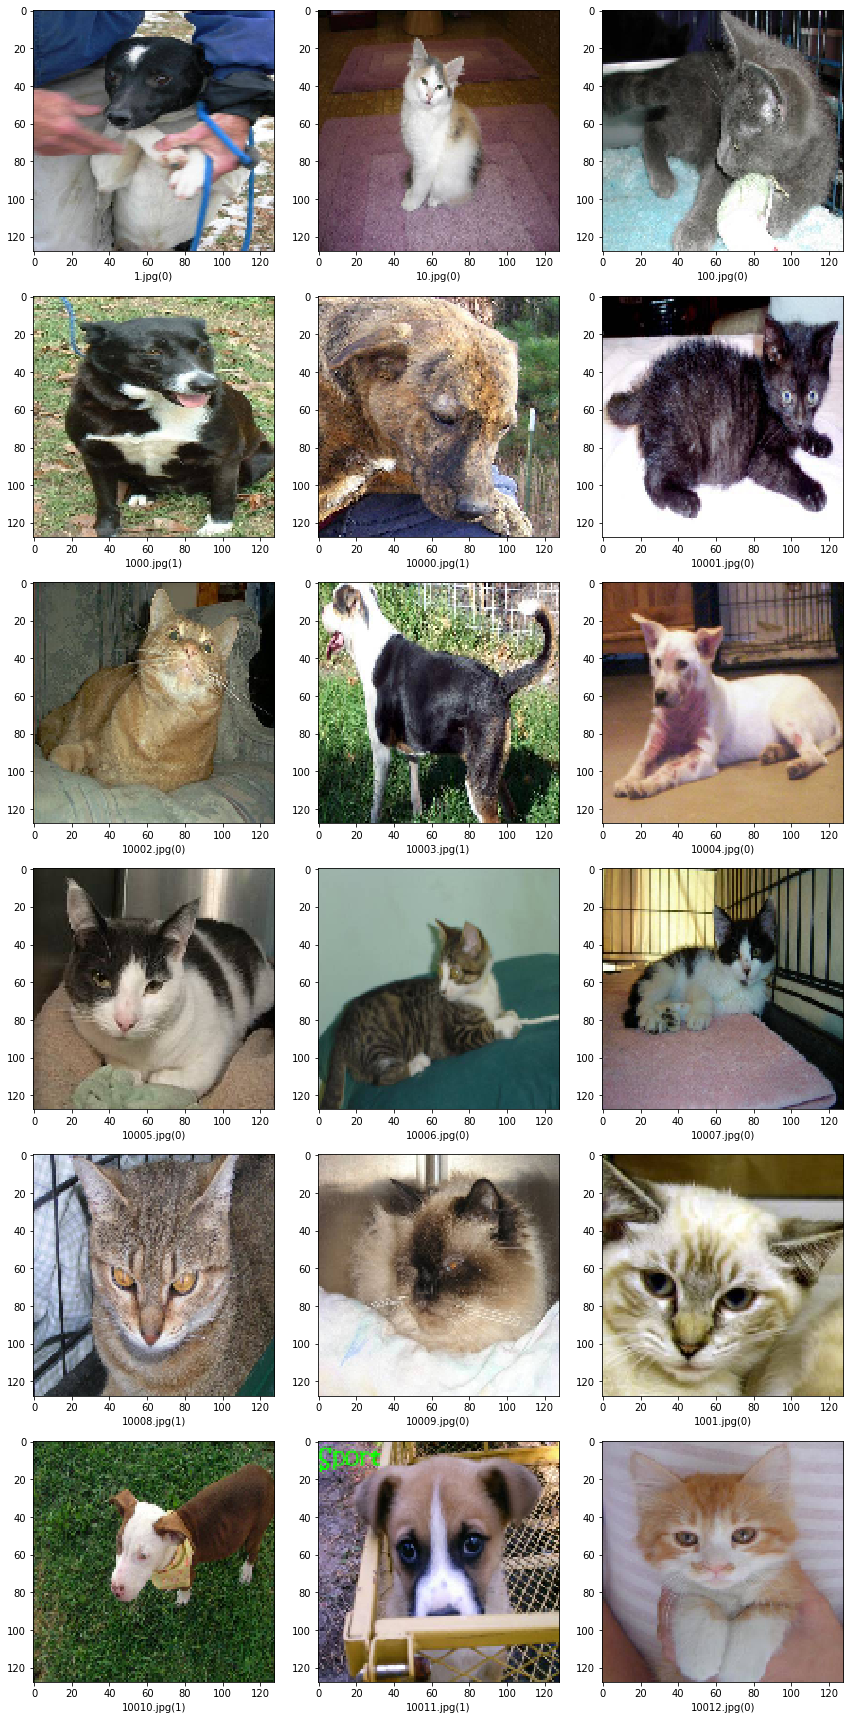

In [54]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./input/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Submission

In [55]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)